# Flights Data Explanation
## by Noura Alzamil

## Investigation Overview

> In the next slides, We will show the worst weekday to fly in, and the worst airline and airport to fly on, in terms of departure and arrival delay.

## Dataset Overview

> This dataset reports flights in the United States, including carriers, arrival and departure delays, and reasons for delays in January 2007. The data set contains 604,580 flights with 26 variables on each flight. The dataset has been extracted from Harvard Dataverse and comes originally from RITA. 
Moreover, two datasets have been merged with the flights' dataset to get the carriers' full names and airports' names. 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
#load the data from 2007.csv 
flights_df= pd.read_csv('2007.csv')

#load the data from carriers.csv file and airports.csv file
carriers_df= pd.read_csv('carriers.csv')
airports_df= pd.read_csv('airports.csv')

In [3]:
#select the first month in 2007 to be analyzed
flights_df=flights_df.loc[flights_df['Month']==1]

#create a copy of the dataframe to clean it
flights_df_clean = flights_df.copy()

#remove the duplicated rows from the dataset
flights_df_clean.drop_duplicates(inplace=True)
flights_df_clean.reset_index(drop=True, inplace=True)

#drop the rows with canceled flights
flights_df_clean=flights_df_clean.drop(flights_df_clean[flights_df_clean['Cancelled']==1].index)

#drop the rows with diverted flights
flights_df_clean=flights_df_clean.drop(flights_df_clean[flights_df_clean['Diverted']==1].index)

#reset indexes
flights_df_clean.reset_index(drop=True, inplace=True)

#merge the carriers' dataframe with flights' dataframe to get the carriers' full names
flights_df_clean = pd.merge(flights_df_clean, carriers_df, how='left',left_on='UniqueCarrier', right_on='Code')

#merge the airports' dataframe with flights' dataframe to get the airports' names
flights_df_clean = pd.merge(flights_df_clean, airports_df[['iata','airport']], how='left',left_on='Origin', right_on='iata')
flights_df_clean = pd.merge(flights_df_clean, airports_df[['iata','airport']], how='left',left_on='Dest', right_on='iata')

#drop unused columns (UniqueCarrier,Cancelled,CancellationCode,Diverted,Code,iata_x,iata_y,Origin, and Dest)
flights_df_clean.drop(['UniqueCarrier', 'Cancelled','CancellationCode','Diverted','Code','iata_x','iata_y','Origin','Dest'], axis = 1,inplace=True) 

#rename Description column,airport_x column, and airport_y column
flights_df_clean.rename({'Description': 'Airline', 'airport_x': 'DepartureAirport','airport_y':'ArrivalAirport'}, axis=1, inplace=True)

#replace the values of DayOfWeek with the actual days(1:Monday, 2:Tuesday, ...etc)
flights_df_clean['DayOfWeek'] = flights_df_clean['DayOfWeek'].map(
    {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'})

#select and store the indexes of the outliers in a list
indexes=flights_df_clean[(flights_df_clean['DepDelay'] < -100) | (flights_df_clean['DepDelay'] > 1250)].index.tolist()

#drop the rows
flights_df_clean=flights_df_clean.drop(flights_df_clean.index[indexes])

#reset indexes
flights_df_clean.reset_index(drop=True,inplace=True)

#select and store the indexes of the outliers in a list
indexes=flights_df_clean[flights_df_clean['ArrDelay'] > 1200].index.tolist()

#drop the rows
flights_df_clean=flights_df_clean.drop(flights_df_clean.index[indexes])

#reset indexes
flights_df_clean.reset_index(drop=True,inplace=True)

#rename the name of US Airways to make it readable on the chart
flights_df_clean['Airline'].replace(
    {"US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)": "US Airways Inc"}, 
    inplace=True)

#remove Inc and Co from the airline name to make the chart more readable
flights_df_clean['Airline'] = flights_df_clean['Airline'].str.replace(' Inc.*| Co.*', '', regex=True)


> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## The Proportion of the Delayed Flights in Jan 2007

> In Jan 2007, 24% of the flights experienced a delay in the arrival time, and  21.1% of the flights experienced a delay in the departure time.

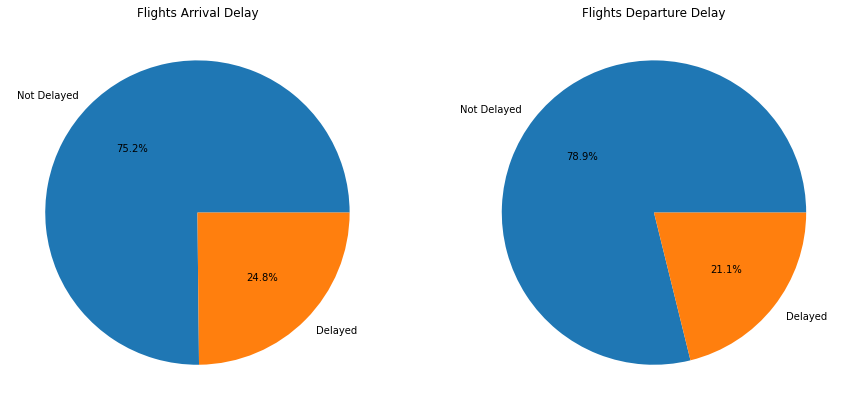

In [4]:
#add a new columns to show if the flight is delayed or not
#A flight is considered delayed when it departed or arrived 15 or more minutes than the schedule
for flight in flights_df_clean:
    flights_df_clean.loc[flights_df_clean['ArrDelay'] >= 15,'FlightArrDel'] = 'Yes'
    flights_df_clean.loc[flights_df_clean['ArrDelay'] < 15, 'FlightArrDel'] = 'No'

for flight in flights_df_clean:
    flights_df_clean.loc[flights_df_clean['DepDelay'] >= 15,'FlightDepDel'] = 'Yes'
    flights_df_clean.loc[flights_df_clean['DepDelay'] < 15, 'FlightDepDel'] = 'No'

#plot two pie charts to illustrates the percentage of the arrival delayed flights and departure delayed flights
f,ax=plt.subplots(1,2,figsize=(15,10))
plt1=flights_df_clean['FlightArrDel'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],labels=['Not Delayed','Delayed'],
                                           textprops={'fontsize': 10})
plt1.set_ylabel('')
plt1.set_title('Flights Arrival Delay')

plt2=flights_df_clean['FlightDepDel'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],labels=['Not Delayed','Delayed'],
                                           textprops={'fontsize': 10})
plt2.set_ylabel('')
plt2.set_title('Flights Departure Delay')

plt.show()

## The Best and Worst Weekdays to Fly in

> The worst two days to fly in are Sunday and Friday since they have the highest delay averages, and the best two days to fly in are Saturday and Wednesday.

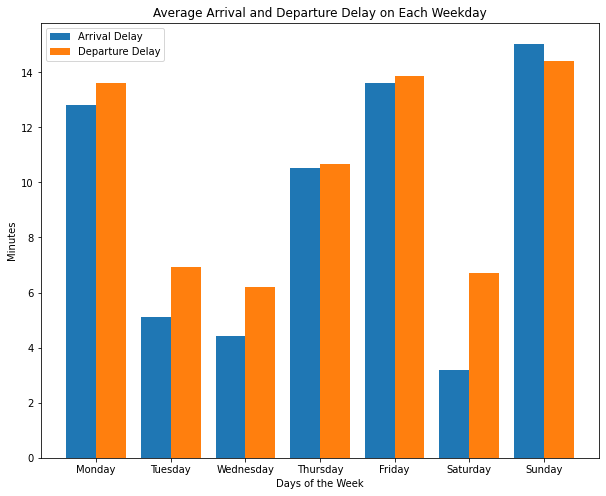

In [8]:
new_index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
             'Friday','Saturday','Sunday']

new_df1=flights_df_clean.groupby('DayOfWeek').mean()['ArrDelay']
new_df1.reindex(new_index)

new_df2=flights_df_clean.groupby('DayOfWeek').mean()['DepDelay']
new_df2.reindex(new_index)

indexes = np.arange(7) 
bar_width = 0.4       

plt.figure(figsize = [10, 8])

plt.bar(indexes, new_df1.reindex(new_index), bar_width, label='Arrival Delay')
plt.bar(indexes + bar_width, new_df2.reindex(new_index), bar_width, label='Departure Delay')

plt.ylabel('Minutes')
plt.title('Average Arrival and Departure Delay on Each Weekday')

plt.xticks(indexes + bar_width / 2, new_index)
plt.legend(loc='best')
plt.xlabel('Days of the Week');
plt.show();


## Number of Flights Performed by Each Airline in Jan 2007
> Southwest Airlines has the largest number of scheduled flights, followed by American Airlines.


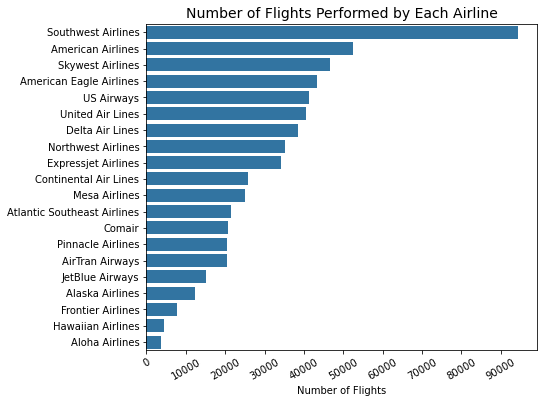

In [9]:
#plot the bar chart and order the bars descendingly 

base_color = sb.color_palette()[0]
plt.figure(figsize=(7,6))

sb.countplot(data=flights_df_clean,y='Airline',color=base_color,
             order=flights_df_clean['Airline'].value_counts().index );
#plt.xticks(rotation=30);
plt.ylabel('');
plt.xlabel('Number of Flights');
plt.title('Number of Flights Performed by Each Airline',fontsize=14);
plt.xticks(np.arange(0, 100000, step= 10000),rotation=30);


## The Worst Airlines to Fly on
> Hawaiian Airlines is the worst airline to fly on since it has the highest average arrival delay time. Most of the Hawaiian Airlines flights are delayed due to air carriers, e.g, maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc. And that can be an indicator of the airline's low performance.

> The most effective two causes that affect the flights' arrival and cause a delay are the air carrier and late aircraft (previous flight using the same aircraft being late).

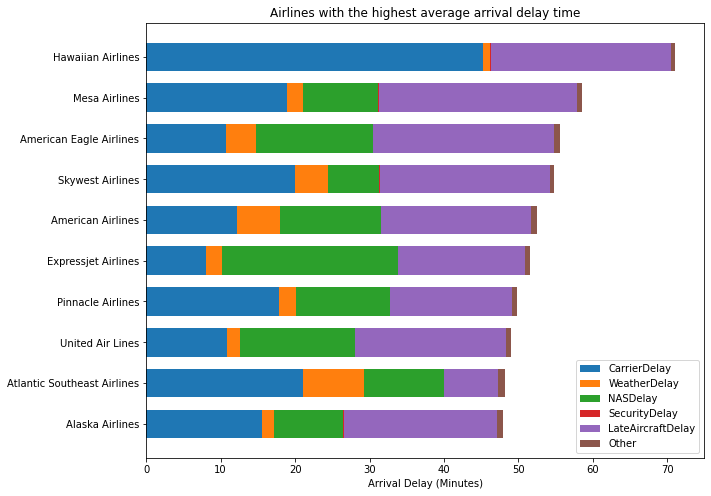

In [10]:

#select only delayed flights
delay_df=flights_df_clean[(flights_df_clean['FlightDepDel']=='Yes')|(flights_df_clean['FlightArrDel']=='Yes')]

#group by the airline and sort by arrival delay
plot=delay_df.groupby('Airline')[['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay','ArrDelay']].mean().reset_index().set_index('Airline').sort_values(by='ArrDelay', ascending=False).head(10)

#sum up all delay causes and store them in a new temporary column 
plot['sum'] = plot['CarrierDelay'] + plot['WeatherDelay'] + plot['NASDelay'] + plot['SecurityDelay'] + plot['LateAircraftDelay']

#subtract the sum of delay causes from the arrival delay to get the "other reasons delay time"
plot['Other'] = plot['ArrDelay'] - plot['sum']
plot.drop(columns = ['sum','ArrDelay'],inplace=True)

plot = plot.iloc[::-1]
    

CarrierDel = plot['CarrierDelay']
WeatherDel = plot['WeatherDelay']
NASDel = plot['NASDelay']
SecurityDel = plot['SecurityDelay']
LateAircraftDel = plot['LateAircraftDelay']
ArrivalDel=plot['Other']
 

indexes = np.arange(10)    
width = 0.7       
    
plt.figure(figsize = [10, 8])
part1 = plt.barh(indexes, CarrierDel, width)
part2 = plt.barh(indexes, WeatherDel, width, left=CarrierDel)
part3 = plt.barh(indexes, NASDel, width, left=WeatherDel+CarrierDel)
part4 = plt.barh(indexes, SecurityDel, width, left=WeatherDel+CarrierDel+NASDel)
part5 = plt.barh(indexes, LateAircraftDel, width, left=WeatherDel+CarrierDel+NASDel+SecurityDel)
part6= plt.barh(indexes, ArrivalDel, width, left=WeatherDel+CarrierDel+NASDel+SecurityDel+LateAircraftDel)

plt.xlabel('Arrival Delay (Minutes)')
plt.title('Airlines with the highest average arrival delay time')
plt.yticks(indexes, plot.index)
plt.xticks(np.arange(0, 80, 10))
plt.legend((part1[0], part2[0], part3[0], part4[0], part5[0],part6[6]), plot.columns, loc='lower right')

plt.xlim([0,75]);
plt.show()  

## The Worst Airports to Fly in
> The worst two airports to fly in are Middle Georgia Regional Airport and Marquette County Airport. They have the longest delay time due to different causes.

> The Middle Georgia Regional Airport and Lewiston Nez Perce County Airport got affected by weather conditions more than the other ten airports that have the longest delay time.

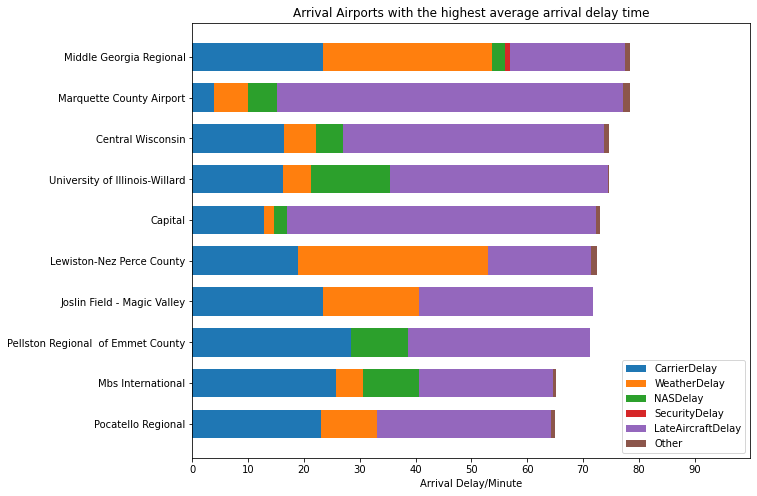

In [11]:
#select only delayed flights
delay_df=flights_df_clean[(flights_df_clean['FlightDepDel']=='Yes')|(flights_df_clean['FlightArrDel']=='Yes')]

#group by arrival airport and sort by aarrival delay
plot=delay_df.groupby('ArrivalAirport')[['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay','ArrDelay']].mean().sort_values(by='ArrDelay', ascending=False).head(10)


#sum up all delay causes and store them in a new temporary column 
plot['sum'] = plot['CarrierDelay'] + plot['WeatherDelay'] + plot['NASDelay'] + plot['SecurityDelay'] + plot['LateAircraftDelay']

#subtract the sum of delay causes from the arrival delay to get the "other reasons delay time"
plot['Other'] = plot['ArrDelay'] - plot['sum']
plot.drop(columns = ['sum','ArrDelay'],inplace=True)

plot = plot.iloc[::-1]
    

CarrierDel = plot['CarrierDelay']
WeatherDel = plot['WeatherDelay']
NASDel = plot['NASDelay']
SecurityDel = plot['SecurityDelay']
LateAircraftDel = plot['LateAircraftDelay']
ArrivalDel=plot['Other']
 

indexes = np.arange(10)    
width = 0.7       
    
plt.figure(figsize = [10, 8])
part1 = plt.barh(indexes, CarrierDel, width)
part2 = plt.barh(indexes, WeatherDel, width, left=CarrierDel)
part3 = plt.barh(indexes, NASDel, width, left=WeatherDel+CarrierDel)
part4 = plt.barh(indexes, SecurityDel, width, left=WeatherDel+CarrierDel+NASDel)
part5 = plt.barh(indexes, LateAircraftDel, width, left=WeatherDel+CarrierDel+NASDel+SecurityDel)
part6= plt.barh(indexes, ArrivalDel, width, left=WeatherDel+CarrierDel+NASDel+SecurityDel+LateAircraftDel)

plt.xlabel('Arrival Delay/Minute')
plt.title('Arrival Airports with the highest average arrival delay time')
plt.yticks(indexes, plot.index)
plt.xticks(np.arange(0, 100, 10))
plt.legend((part1[0], part2[0], part3[0], part4[0], part5[0],part6[6]), plot.columns, loc='lower right')

plt.xlim([0,100]);
plt.show()    

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!

In [ ]:
!jupyter nbconvert flights_data_slides.ipynb --to slides --post serve --template output_toggle

[NbConvertApp] Converting notebook flights_data_slides.ipynb to slides
[NbConvertApp] Writing 478662 bytes to flights_data_slides.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/flights_data_slides.slides.html
Use Control-C to stop this server
